In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import shap
import statsmodels.api as sm
from scipy import stats

import os
import src

from dotenv import load_dotenv

C:\Users\markelov.GIDROMETALL\Miniconda3\envs\ac\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Необходимые опции

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

Загрузка данных и подготовка

In [4]:
# load_dotenv(override=True)
#
# WORK_DIR = os.getenv("RAW_DIR")
# FILE_NAME = os.getenv("RAW_DF_NAME")
#
# filepath = f'..\\..\\{WORK_DIR}\\{FILE_NAME}'
#
# df1 = pd.read_csv(filepath + '101.zip', index_col=0, parse_dates=True)
# df2 = pd.read_csv(filepath + '102.zip', index_col=0, parse_dates=True)
# df3 = pd.read_csv(filepath + '103.zip', index_col=0, parse_dates=True)
# df4 = pd.read_csv(filepath + '104.zip', index_col=0, parse_dates=True)

In [4]:
load_dotenv(override=True)

WORK_DIR = os.getenv("RAW_DIR")
filepath = f'..\\..\\{WORK_DIR}\\df_raw_test.zip'

df = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [5]:
df.shape

(96738, 53)

In [5]:
# cols = [
#     'Fel_1',
#     'Fel_2',
#     'D_SL',
#     'QQ_C1',
#     'QQ_C2',
#     'QQ_C3',
#     'QQ_C4',
#     'QQ_C5',
#     'O2_tot',
#     'QQ_tot',
#     'Sl_tot',
#     'O2_C1',
#     'O2_C2',
#     'O2_C3',
#     'O2_C4',
#     'O2_C5',
#     'AC_level',
#     'AC_rbk_open',
#     'AC_valve_open',
#     'P_H2O',
#     'P_O2',
#     'P_tot',
#     'P_valve',
#     'P_tot_2',
#     'T_C1',
#     'T_C2',
#     'T_C3',
#     'T_C4',
#     'T_C5',
#     'T_abg',
#     'P_O2_in',
#     'FT1_level',
#     'FT1_P',
#     'FT1_T_in',
#     'FT1_T',
#     'FT2_level',
#     'FT2_P',
#     'FT2_T',
#     'Cond_Q',
#     'Cond_level',
#     'Cond_valve',
#     'O2_conc_1',
#     'O2_conc_2',
#     'Fe',
#     'Stot',
#     'SO4',
#     'As',
#     'Corg',
#     'Ctot',
#     'Fe2+',
#     'D_S',
#     'D_SL_H'
# ]
#
# df1.columns = cols
# df2.columns = cols
# df3.columns = cols
# df4.columns = cols

# Анализ данных

Оставим только те данные, когда автоклав работал

In [6]:
df['work'] = np.where((df['Fel_1'] + df['Fel_2'] >= 20), 1, 0)
df.reset_index(inplace=True)
df.drop(df[df['work'] == 0].index, inplace=True)
df.drop('work', axis=1, inplace=True)

df = df.set_index('index')
df.index.name = ""

print(df.shape)

(51737, 53)


Проверим массив данных на пустые значения

In [9]:
null_check = df.isna().sum()
null_check[null_check > 0]

Fe        49164
Stot      48877
SO4       51066
As        49158
Corg      48895
Ctot      48883
Fe2+          8
D_S       47825
D_SL_H    48071
dtype: int64

## Целевая метрика - концентрация железа 2+

In [56]:
df_fe = df[['Fe2+', 'ac']].copy()
df_fe = df_fe.assign(year = df_fe.index.year)

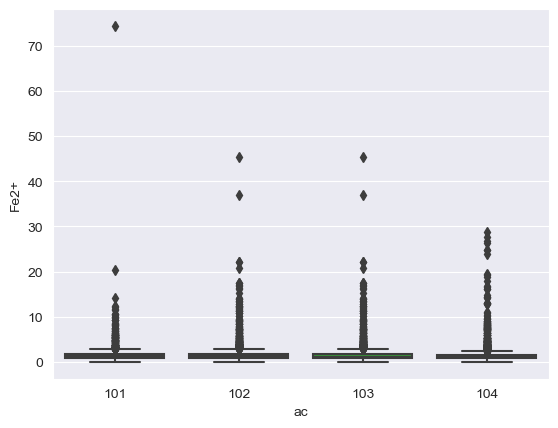

In [57]:
sns.boxplot(data=df_fe, y='Fe2+', x='ac');

In [58]:
df_fe.groupby(by=['ac', 'year']).mean()

Fe2+
ac  year      
101 2019  0.76
    2020  1.06
    2021  1.72
102 2019  0.88
    2020  1.08
    2021  1.80
103 2019  0.88
    2020  1.08
    2021  1.83
104 2019  0.91
    2020  1.17
    2021  1.67

In [10]:
df_fe[(df_fe['ac'] == '103') & (df_fe['year'] == 2019)]['Fe2+'].describe()

count   2,438.00
mean        0.88
std         0.71
min         0.00
25%         0.64
50%         0.81
75%         1.17
max        11.40
Name: Fe2+, dtype: float64

In [11]:
df_fe[(df_fe['ac'] == '103') & (df_fe['year'] == 2019)]['Fe2+'].count()

2438

In [12]:
df_fe[(df_fe['ac'] == '103') & (df_fe['year'] == 2019) & (df_fe['Fe2+'] == 0)]['Fe2+'].count()

371

Что мы видим:
1. Есть значения, которые сильно большие и вызывают сомнения. Скорее всего это ошибки анализа на железо или это точки представляют совсем плохой режим, может во время запуска. **Решение - убрать все точки по концентрации железа больше 20 г/л.** Этот параметр может быть потом изменен.
2. Могут быть значения концентрации равные 0, это скорее всего отсутствие реальных данных, чем результат измерения. **Решение - убрать все значения концентрации равные 0.** Таких значений в реальной жизни быть не может, следовательно, это ошибки или отсутствие анализов.

Эти правила нужно будет добавить в функцию очистки данных!!!



In [14]:
before_zeros_del = df_fe.shape[0]

In [15]:
FE_MAX = 20
FE_MIN = 0

df_fe.drop(df_fe[df_fe['Fe2+'] == FE_MIN].index, inplace=True)
df_fe.drop(df_fe[df_fe['Fe2+'] > FE_MAX].index, inplace=True)

In [18]:
after_zeroes_del = df_fe.shape[0]
print(f'Всего с нулевыми значениями было удалено {before_zeros_del - after_zeroes_del} объектов, что составляло {(before_zeros_del - after_zeroes_del) / before_zeros_del * 100:.1f} %.')
print(f'Осталось {after_zeroes_del} объектов.')

Всего с нулевыми значениями было удалено 3410 объектов, что составляло 6.6 %.
Осталось 48319 объектов.


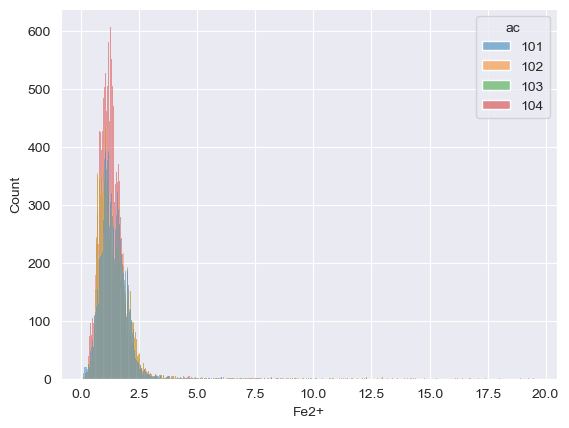

In [20]:
ax = sns.histplot(data=df_fe.reset_index(), x='Fe2+', hue='ac');

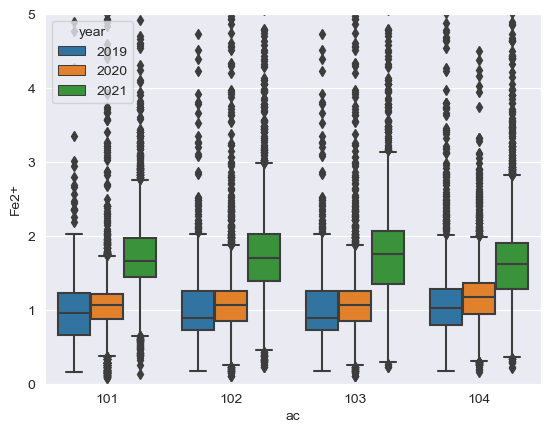

In [21]:
ax = sns.boxplot(data=df_fe, y='Fe2+', x='ac', hue='year', whis=1.5)
ax.set_ylim([0, 5]);

Попробуем посчитать сколько точек выходит за 3 сигмы.

In [22]:
x = df_fe.loc[(df_fe['year'] == 2021) & (df_fe['ac'] == '101')]['Fe2+']
print(f'Разброс ≈95% интервал {x.mean():.2f} ± {x.std() * 2:.2f}')

Разброс ≈95% интервал 1.73 ± 1.28


In [23]:
print(f'Медиана: {x.median()}')
print(f'Q1: {x.quantile(0.25)}, Q3: {x.quantile(0.75)}')
IRQ = x.quantile(0.75) - x.quantile(0.25)
print(f'IRQ: {IRQ:.2f}')
min_level = x.quantile(0.25) - 1.5 * IRQ
max_level = x.quantile(0.75) + 1.5 * IRQ
print(f'Min level: {min_level:.2f}')
print(f'Max level: {max_level:.2f}')


Медиана: 1.66
Q1: 1.44, Q3: 1.97
IRQ: 0.53
Min level: 0.64
Max level: 2.77


In [24]:
def stat_min_max(array, scale=1.5) -> tuple:
    irq = array.quantile(0.75) - array.quantile(0.25)
    min_level = array.quantile(0.25) - scale * irq
    max_level = array.quantile(0.75) + scale * irq

    return min_level, max_level


In [25]:
for ac in ['101', '102', '103', '104']:
    print(f'Автоклав {ac}')

    for year in [2019, 2020, 2021]:

        print(f'Год {year}')
        ar = df_fe.loc[(df_fe['year'] == year) & (df_fe['ac'] == ac)]
        min_l, max_l = stat_min_max(ar['Fe2+'])

        print(f'Min level {min_l:.2f}, max level {max_l:.2f}')

        out_value_count = ar.query("@min_l < `Fe2+` > @max_l")['Fe2+'].count()

        in_value_count = ar.shape[0]

        print(
            f"Общее число точек: {in_value_count}, из них выпадает более чем на 3 IRQ: {out_value_count}, что составляет {out_value_count / in_value_count * 100:.2f}%")

    print('*' * 10)

Автоклав 101
Год 2019
Min level -0.19, max level 2.08
Общее число точек: 1204, из них выпадает более чем на 3 IRQ: 24, что составляет 1.99%
Год 2020
Min level 0.37, max level 1.73
Общее число точек: 4165, из них выпадает более чем на 3 IRQ: 135, что составляет 3.24%
Год 2021
Min level 0.64, max level 2.77
Общее число точек: 5412, из них выпадает более чем на 3 IRQ: 142, что составляет 2.62%
**********
Автоклав 102
Год 2019
Min level -0.08, max level 2.04
Общее число точек: 2058, из них выпадает более чем на 3 IRQ: 50, что составляет 2.43%
Год 2020
Min level 0.23, max level 1.88
Общее число точек: 4224, из них выпадает более чем на 3 IRQ: 146, что составляет 3.46%
Год 2021
Min level 0.43, max level 2.99
Общее число точек: 5524, из них выпадает более чем на 3 IRQ: 149, что составляет 2.70%
**********
Автоклав 103
Год 2019
Min level -0.08, max level 2.04
Общее число точек: 2058, из них выпадает более чем на 3 IRQ: 50, что составляет 2.43%
Год 2020
Min level 0.23, max level 1.88
Общее числ

Сильно выпадающих значений не очень много, можно на первое время их оставить. Если модель будет сильно ошибаться в пиках, то можно немного сгладить данные.

### Соответствие распределения концентрации железа нормальному

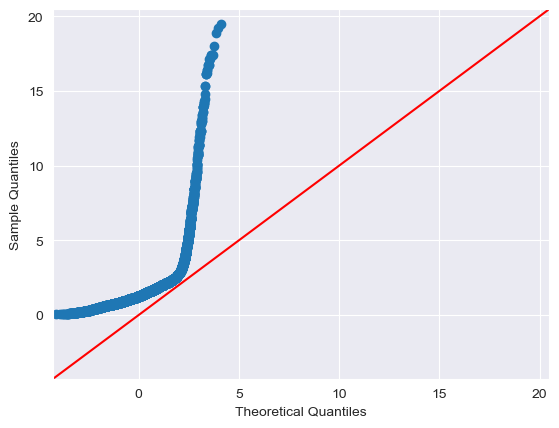

In [28]:
sm.qqplot(df_fe['Fe2+'], line='45');

Распределение вообще не похоже на нормальное, имеет место большой хвост. Есть техники приведения распределения к номральному виду. Попробуем применить Box-Cox метод.

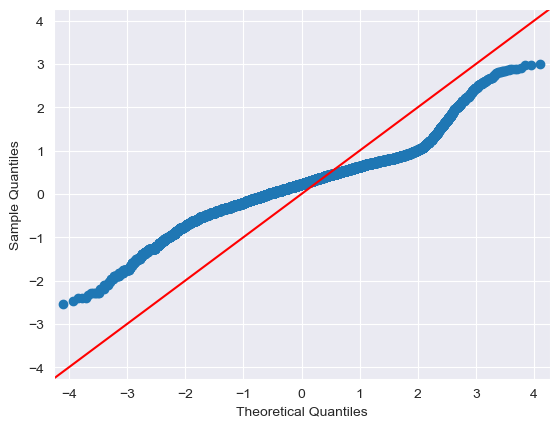

In [29]:
df_fe_norm, _ = stats.boxcox(df_fe['Fe2+'])
sm.qqplot(df_fe_norm, line='45');

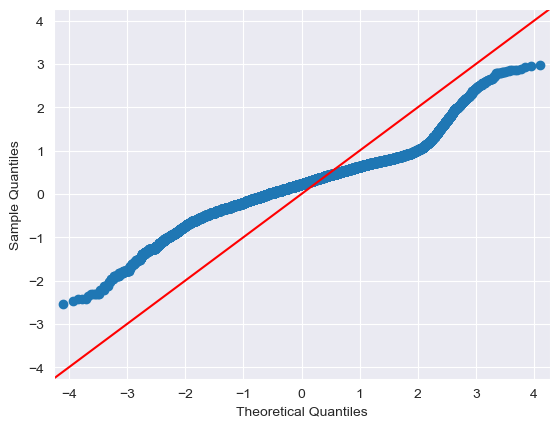

In [30]:
df_fe_ln = np.log(df_fe['Fe2+'])
sm.qqplot(df_fe_ln, line='45');

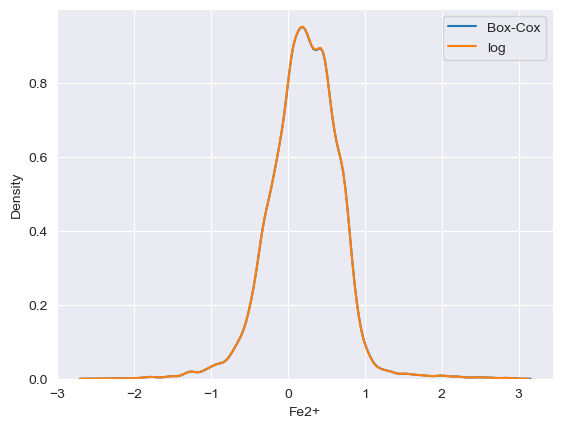

In [31]:
ax = sns.kdeplot(df_fe_norm, label='Box-Cox')
sns.kdeplot(df_fe_ln.reset_index()['Fe2+'], label='log')
ax.legend()
plt.show()

Теперь распределение целевой переменной уже ближе к нормальному. В целом это надо запомнить и применить для тюнинга модели.

## Анализ состава исходного сырья

Посмотрим, как исходное сырье распределено во времени. Может быть можно выделить различные типы сырья и добавить категориальные признаки.

In [10]:
df.columns

Index(['Fel_1', 'Fel_2', 'D_SL', 'QQ_C1', 'QQ_C2', 'QQ_C3', 'QQ_C4', 'QQ_C5',
       'O2_tot', 'QQ_tot', 'Sl_tot', 'O2_C1', 'O2_C2', 'O2_C3', 'O2_C4',
       'O2_C5', 'AC_level', 'AC_rbk_open', 'AC_valve_open', 'P_H2O', 'P_O2',
       'P_tot', 'P_valve', 'P_tot_2', 'T_C1', 'T_C2', 'T_C3', 'T_C4', 'T_C5',
       'T_abg', 'P_O2_in', 'FT1_level', 'FT1_P', 'FT1_T_in', 'FT1_T',
       'FT2_level', 'FT2_P', 'FT2_T', 'Cond_Q', 'Cond_level', 'Cond_valve',
       'O2_conc_1', 'O2_conc_2', 'Fe', 'Stot', 'SO4', 'As', 'Corg', 'Ctot',
       'Fe2+', 'D_S', 'D_SL_H', 'ac'],
      dtype='object')

In [11]:
df_chem = df.loc[:, ['Fe', 'Stot', 'SO4', 'As', 'Corg', 'Ctot', 'Fe2+', 'D_S', 'D_SL_H', 'ac']]

In [12]:
int_cols = [
    'Fe',
    'Stot',
    'SO4',
    'As',
    'Corg',
    'Ctot',
    'D_S',
    'D_SL_H'
]

df_chem[int_cols] = df_chem.loc[:, int_cols].interpolate(method='time')

In [14]:
df_chem = df_chem.dropna()

In [15]:
df_chem.head()

,Fe,Stot,SO4,As,Corg,Ctot,Fe2+,D_S,D_SL_H,ac
,,,,,,,,,,
2019-09-19 07:00:00,20.08,25.20,0.31,7.97,0.38,0.83,0.84,"3,900.00","1,599.17",101
2019-09-19 08:00:00,20.07,24.87,0.32,7.97,0.19,0.82,0.00,"3,866.67","1,596.81",101
2019-09-19 09:00:00,20.07,24.53,0.34,7.97,0.19,0.82,0.00,"3,833.33","1,594.44",101
2019-09-19 10:00:00,20.07,24.20,0.35,7.97,0.20,0.81,0.60,"3,800.00","1,592.08",101
2019-09-19 11:00:00,20.06,23.87,0.36,7.97,0.21,0.81,0.66,"3,766.67","1,589.72",101


Удалим строки c концентрациями Fe2+ меньше и равными 0, а также больше 20 г/л.

In [17]:
FE_MAX = 20
FE_MIN = 0

df_chem.drop(df_chem[df_chem['Fe2+'] == FE_MIN].index, inplace=True)
df_chem.drop(df_chem[df_chem['Fe2+'] > FE_MAX].index, inplace=True)

In [19]:
df_chem.shape

(47923, 10)

In [21]:
df_chem.drop('ac', axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
Fe,"47,923.00",26.91,3.27,11.27,25.19,27.15,29.13,47.19
Stot,"47,923.00",25.91,2.42,8.93,24.81,26.43,27.24,34.20
SO4,"47,923.00",17.69,8.14,0.05,21.50,21.50,21.50,24.40
As,"47,923.00",7.85,1.92,0.37,6.44,8.16,8.90,26.80
Corg,"47,923.00",0.55,0.96,0.10,0.39,0.52,0.63,71.00
Ctot,"47,923.00",1.00,0.29,0.18,0.87,1.01,1.11,25.30
Fe2+,"47,923.00",1.39,0.87,0.08,0.94,1.26,1.65,19.50
D_S,"47,923.00","3,843.05",165.01,"3,200.00","3,790.83","3,900.00","3,920.00","4,300.00"
D_SL_H,"47,923.00","1,650.64",70.30,"1,140.35","1,609.00","1,638.67","1,695.33","3,891.67"


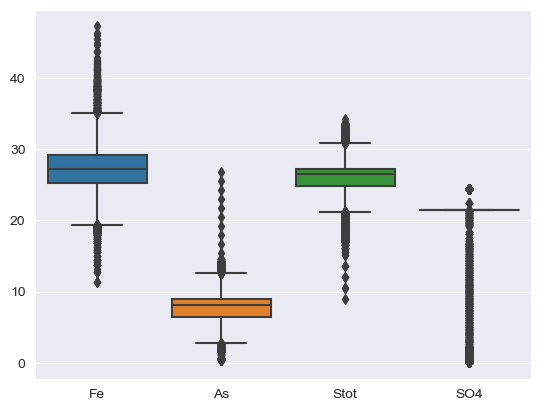

In [34]:
sns.boxplot(data=df_chem[['Fe', 'As', 'Stot', 'SO4']]);

Видно, что данные по сульфатной сере скорее всего ошибочны. Для дальнейшего анализа предлагается их исключить.

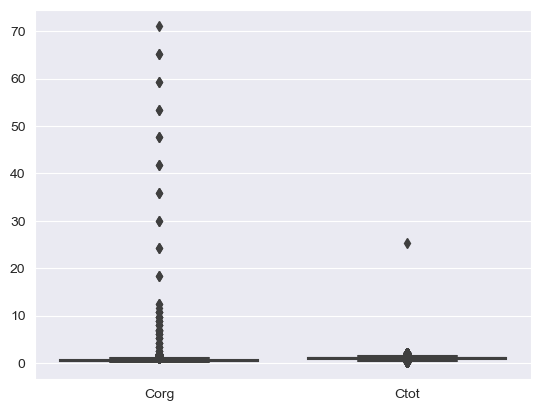

In [35]:
sns.boxplot(data=df_chem[['Corg', 'Ctot']]);

Данные по органическому углероду имеют странные значения. Посмотрим подробнее

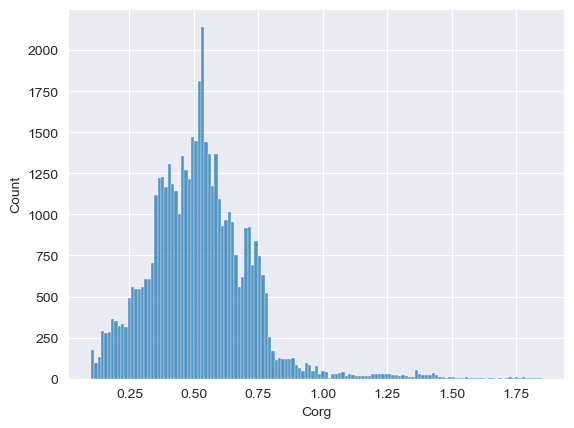

In [47]:
sns.histplot(data=df_chem.reset_index(), x='Corg');

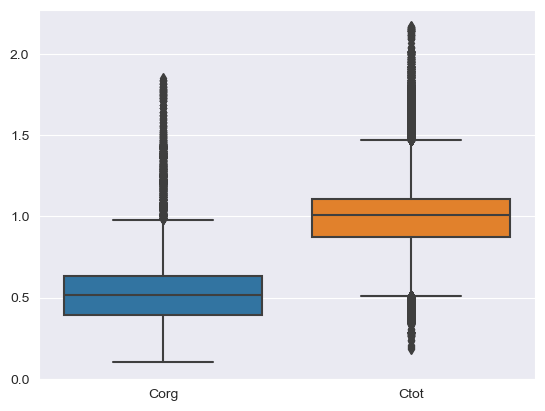

In [48]:
sns.boxplot(data=df_chem[['Corg', 'Ctot']]);

In [49]:
df_chem.shape

(47851, 10)

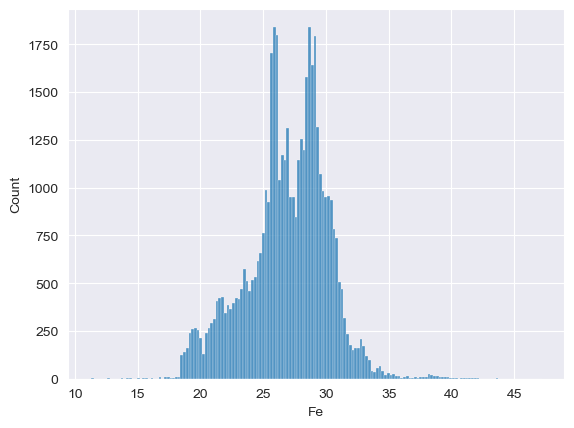

In [57]:
sns.histplot(data=df_chem.reset_index(), x='Fe');

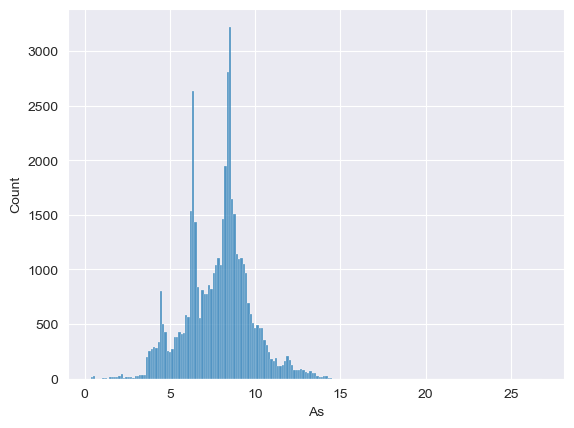

In [51]:
sns.histplot(data=df_chem.reset_index(), x='As');

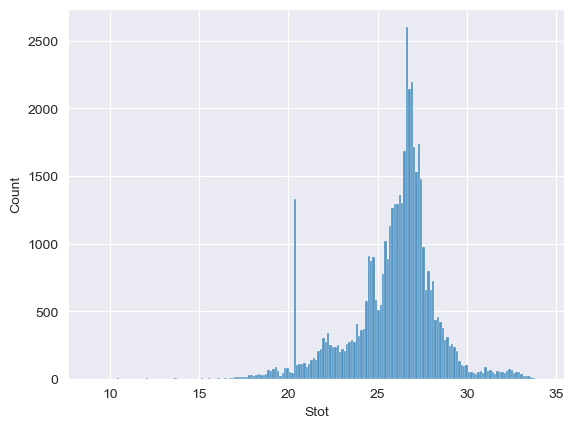

In [53]:
sns.histplot(data=df_chem.reset_index(), x='Stot');

In [62]:
df_chem.loc[df_chem['As'] > 15]

,Fe,Stot,SO4,As,Corg,Ctot,Fe2+,D_S,D_SL_H,ac
,,,,,,,,,,
2019-01-26 00:00:00,28.54,26.80,24.40,26.80,0.33,1.01,1.63,"3,900.00","1,579.51",104
2019-01-26 02:00:00,28.49,26.80,24.40,25.54,0.33,1.01,1.41,"3,900.00","1,577.99",104
2019-01-26 04:00:00,28.47,26.80,24.40,24.27,0.33,1.01,1.41,"3,900.00","1,576.46",104
2019-01-26 06:00:00,28.44,26.80,24.40,23.01,0.32,1.01,1.18,"3,900.00","1,574.93",104
2019-01-26 08:00:00,28.41,26.80,24.40,21.74,0.32,1.01,1.07,"3,900.00","1,561.60",104
2019-01-26 10:00:00,28.39,26.80,24.40,20.48,0.32,1.01,1.12,"3,900.00","1,563.12",104
2019-01-26 12:00:00,28.36,26.80,24.40,19.21,0.32,1.01,1.74,"3,900.00","1,564.65",104
2019-01-26 14:00:00,28.33,26.80,24.40,17.95,0.31,1.02,1.29,"3,900.00","1,566.18",104
2019-01-26 16:00:00,28.31,26.80,24.40,16.68,0.31,1.02,1.35,"3,900.00","1,567.71",104


По мышьяку скорее всего имеет место ошибка анализа, лучше эти данные удалить. Для границы можно взять значение в 16 %. Большие значения получены в только в один день и скорее всего являются ошибкой анализа.

По распределению железа наблюдается странная граница на 18 %, меньше 18 % железа имеют всего 68 точек, а вот меньше 19 % уже 453.

In [69]:
df_chem.loc[df_chem['Fe'] < 18]

,Fe,Stot,SO4,As,Corg,Ctot,Fe2+,D_S,D_SL_H,ac
,,,,,,,,,,
2020-01-12 00:00:00,17.42,21.85,21.50,6.42,0.66,1.67,1.18,"3,820.00","1,608.17",101
2020-01-12 01:00:00,16.80,21.90,21.50,6.32,0.66,1.67,1.02,"3,820.00","1,608.00",101
2020-01-12 02:00:00,16.19,21.95,21.50,6.21,0.66,1.66,0.98,"3,820.00","1,607.83",101
2020-01-12 03:00:00,15.58,22.00,21.50,6.11,0.65,1.65,0.91,"3,820.00","1,607.67",101
2020-01-12 04:00:00,14.97,22.05,21.50,6.00,0.65,1.64,0.89,"3,820.00","1,607.50",101
...,...,...,...,...,...,...,...,...,...,...
2020-01-12 07:00:00,13.14,21.90,21.50,4.33,0.64,1.74,0.57,"3,820.00","1,607.00",104
2021-12-11 04:00:00,17.90,21.27,21.50,3.67,0.36,0.94,1.75,"3,900.00","1,585.00",104
2021-12-11 05:00:00,17.63,21.25,21.50,3.62,0.36,0.93,1.81,"3,900.00","1,585.00",104


Почистим данные по химии

In [71]:
CORG_MAX = 2
CTOT_MAX = 5
AS_S_MAX = 16

df_chem.drop(df_chem[df_chem['Corg'] > CORG_MAX].index, inplace=True)
df_chem.drop(df_chem[df_chem['Ctot'] > CTOT_MAX].index, inplace=True)
df_chem.drop(df_chem[df_chem['As'] > AS_S_MAX].index, inplace=True)
df_chem.drop('SO4', axis=1, inplace=True)

Посмотрим на статистики получившегося массива

In [73]:
df_chem.describe().T

,count,mean,std,min,25%,50%,75%,max
Fe,"47,842.00",26.91,3.27,11.27,25.19,27.15,29.13,47.19
Stot,"47,842.00",25.91,2.42,8.93,24.81,26.43,27.24,34.20
As,"47,842.00",7.84,1.91,0.37,6.44,8.16,8.90,15.42
Corg,"47,842.00",0.52,0.20,0.10,0.39,0.52,0.63,1.85
Ctot,"47,842.00",1.00,0.27,0.18,0.87,1.01,1.11,2.17
Fe2+,"47,842.00",1.39,0.87,0.08,0.95,1.26,1.65,19.50
D_S,"47,842.00","3,843.23",165.04,"3,200.00","3,791.67","3,900.00","3,920.00","4,300.00"
D_SL_H,"47,842.00","1,650.74",70.30,"1,140.35","1,609.00","1,639.00","1,695.42","3,891.67"
ac,"47,842.00",102.63,1.13,101.00,102.00,103.00,104.00,104.00


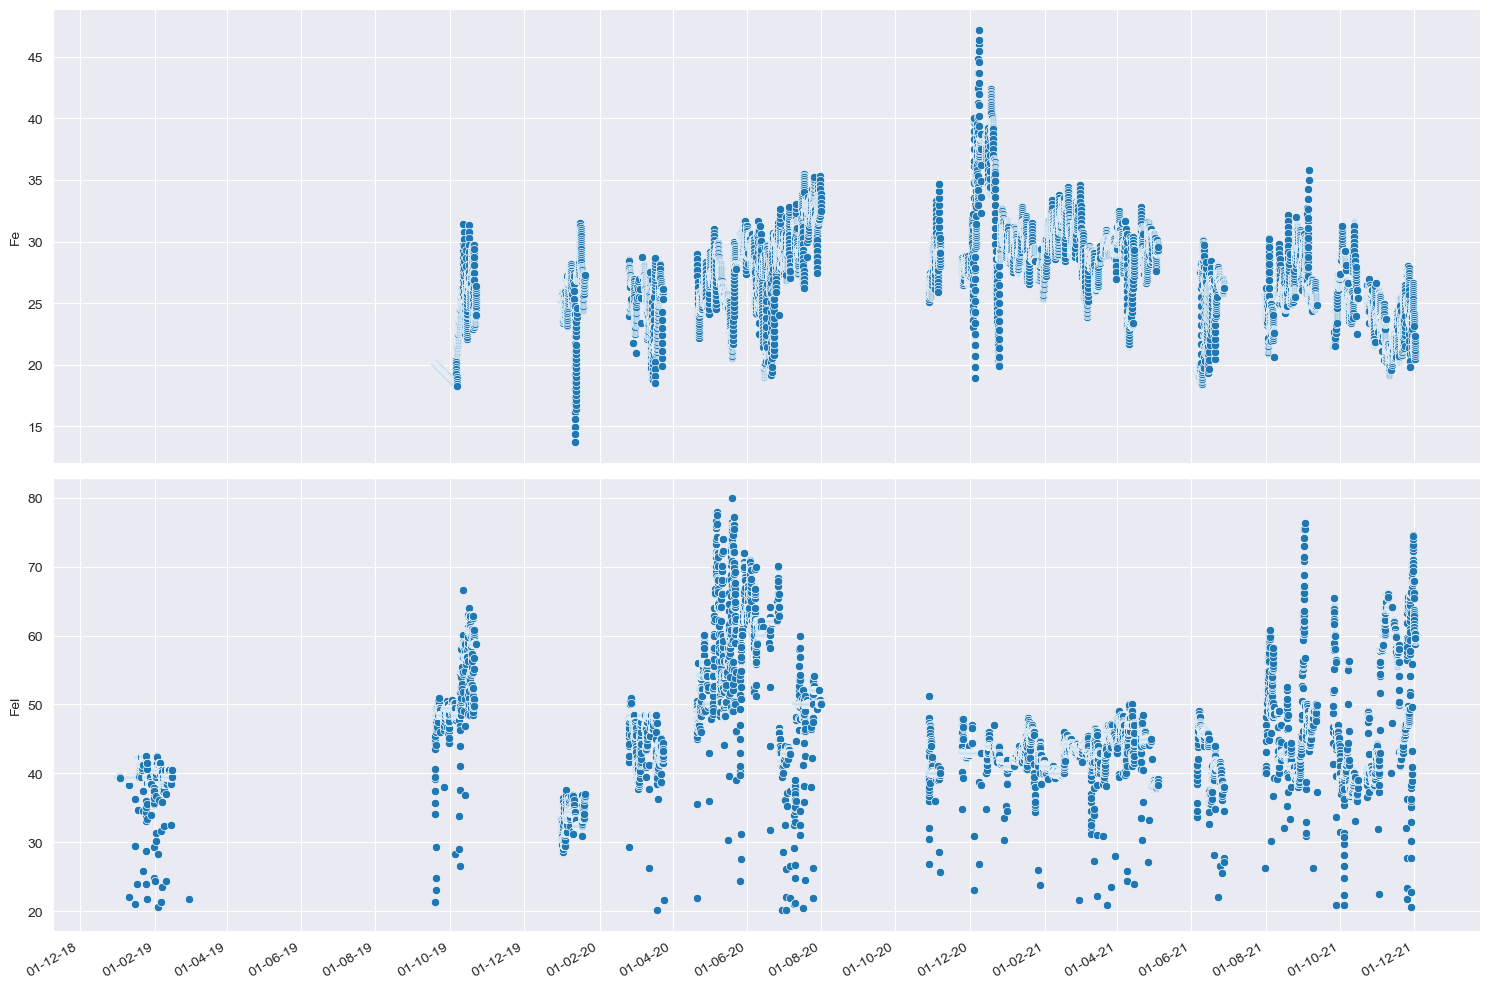

In [89]:
f, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True)

sns.scatterplot(data=df_chem[df_chem['ac'] == 101], y='Fe', x=df_chem[df_chem['ac'] == 101].index, ax=ax[0])

df['Fel'] = df['Fel_1'] + df['Fel_2']
sns.scatterplot(data=df[df['ac'] == 101], y='Fel', x=df[df['ac'] == 101].index, ax=ax[1])

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))

f.autofmt_xdate()
f.tight_layout()

plt.show()